# In this analysis we will provide the ratio of statistical tests for image calssification task

## imports

In [1]:
conf_int = 0.95
seed_lim = 5
"test type can be utest, brunner, t_test"
test_type = 'brunner'
estimated_max_val = 120
sample_size = 10000

In [2]:
# Third-party imports
%matplotlib inline
import json
import matplotlib.pyplot as plt
import yaml
from IPython.display import display
     

In [3]:
from src.RQ1_forecast import *

In [4]:
from numpy import random

def sampling_group(all_mapes, seed_lim):
    # assert (2 * seed_lim) < 100
    # total_sample = random.choice(all_mapes, (2*seed_lim), replace=False)
    func_sample_0 = random.choice(all_mapes, seed_lim, replace=False)
    func_sample_1 = random.choice(all_mapes, seed_lim, replace=False)
    # func_sample_0 = total_sample[0:seed_lim]
    # func_sample_1 = total_sample[seed_lim:(2*seed_lim)]

    return func_sample_0, func_sample_1


def utest(sample_0, sample_1, confidence_interval, test_type):
    # calculating the u test
    from scipy.stats import mannwhitneyu, ttest_ind, brunnermunzel, ks_2samp

    # we use the alternative less whcih means. the distribution underlying x is stochastically less than the distribution underlying y
    U1, p_utest = mannwhitneyu(sample_0, sample_1)
    w, p_brunner = brunnermunzel(sample_0, sample_1, alternative='two-sided')
    ks_prob, p_ks = ks_2samp(sample_0, sample_1)
    stat_t, p_t = ttest_ind(sample_0, sample_1)

    p_val_dict = {
        'utest': p_utest,
        'brunner': p_brunner,
        't_test': p_t,
        'ks': p_ks,
    }

    p = p_val_dict[test_type]
    p_lim = 1.0 - confidence_interval
    # print(f'pvalue{p}\t plim{p_lim}')
    # sample_0 is not lower than sample_1
    if p > p_lim:
        return 0
    # sample_0 is lower than sample_1
    else:
        return 1
        
def ratio_exp(mape_arr, seed_lim, sampling_lim, confidence_interval, test_type):
    "gets an array of mape scores, then sample 2 sample of seed_lim size, afterwards perform the utest"
    ratio = np.zeros(sampling_lim)
    for i in range(sampling_lim):
        sample_0, sample_1 = sampling_group(mape_arr, seed_lim=seed_lim)
        # sample_1 = sample_1*100
        # sample_0 = sample_0*100
        ratio[i] = utest(sample_0, sample_1, confidence_interval=confidence_interval, test_type=test_type)
    return(ratio[ratio==1].shape[0])

In [5]:
pd.options.display.max_columns = None

In [6]:
def plot_kde(arr, conf_name, dataset_name, add_title=False):
    pd.Series(arr).plot.kde(0.5, linewidth=3)
    
    plt.xlabel('MAPE')
    # plt.title(f'deep{conf_name}_{dataset_name}')
    if(dataset_name == 'electricity_both_ep100'):
        plt.xlim(-1,12)
        if add_title:
            plt.title('electricity_both_ep100', fontsize=26)
    elif(dataset_name == 'exchange_rate_both_ep100'):
        plt.xlim(-1,12)
        if add_title:
            plt.title('exchange rate_both_ep100', fontsize=26)
    elif(dataset_name == 'solar_nips_both_ep100'):
        plt.xlim(-1,12)
        if add_title:
            plt.title('solar nips_both_ep100', fontsize=26)
    elif(dataset_name == 'traffic_nips_both_ep100'):
        plt.xlim(-1,6)
        if add_title:
            plt.title('traffic nips_both_ep100', fontsize=26)
    plt.savefig(f"/home/dev/deepts/plots/kde_func/epoch100/kde_{conf_name}_{dataset_name}", dpi=900)
    plt.show()


def mape_mean_array_dataset(conf_name, dataset_name, add_title=False):
    with open(f'/home/dev/deepts/configs/ks_config_{conf_name}.yaml', "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)
    data_address_val=config[dataset_name]

    metrics_list1_val = read_csv_result('metrics.csv', data_address_val)
    mape_dataset = np.zeros(len(metrics_list1_val))
    for idx, metric_elem in enumerate(metrics_list1_val):
        mape_dataset[idx] = metric_elem['MAPE'].mean()
    # plot_kde(mape_dataset, conf_name=conf_name, dataset_name=dataset_name, add_title=add_title)
    return mape_dataset

In [7]:
# fixing the seeds here
seed_of_seed = 0
np.random.seed(seed_of_seed)
import random as rnd
rnd.seed(seed_of_seed)

In [8]:
# reading the csv files
mobile_add = f'/datadrive2/image_classification/exp/mobilenet_cifar10_accuracy.csv'
resnet_add = f'/datadrive2/image_classification/exp/resnet_cifar10_accuracy.csv'
dnsnet_add = f'/datadrive2/image_classification/exp/densenet_cifar10_accuracy.csv'

mobile_acc_list = list(pd.read_csv(mobile_add, index_col=[0])['accuracy'])
resnet_acc_list = list(pd.read_csv(resnet_add, index_col=[0])['accuracy'])
dnsnet_acc_list = list(pd.read_csv(dnsnet_add, index_col=[0])['accuracy'])

## Sample mape values, then perform the utest

In [9]:
mobile_ratio = ratio_exp(mobile_acc_list, seed_lim=seed_lim, sampling_lim=sample_size, confidence_interval=conf_int, test_type=test_type)
dense_ratio = ratio_exp(dnsnet_acc_list, seed_lim=seed_lim, sampling_lim=sample_size, confidence_interval=conf_int, test_type=test_type)
res_ratio = ratio_exp(resnet_acc_list, seed_lim=seed_lim, sampling_lim=sample_size, confidence_interval=conf_int, test_type=test_type)


[mobile_ratio, dense_ratio, res_ratio]

[199, 237, 198]

In [10]:
experiments_array_ep20 = np.array([     
                                        [mobile_ratio],
                                        [dense_ratio],
                                        [res_ratio],
                             ]
                     )

In [11]:
experiments_df_ep20 = pd.DataFrame(data=experiments_array_ep20, 
                              index=['MobileNet', 'DenseNet', 'ResNet'], 
                              columns=['CIFAR10'])
experiments_df_ep20

,CIFAR10
MobileNet,199
DenseNet,237
ResNet,198


In [12]:
experiments_df_ep20.to_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds{seed_lim}_{test_type}_size{sample_size}_conf{conf_int}.csv")

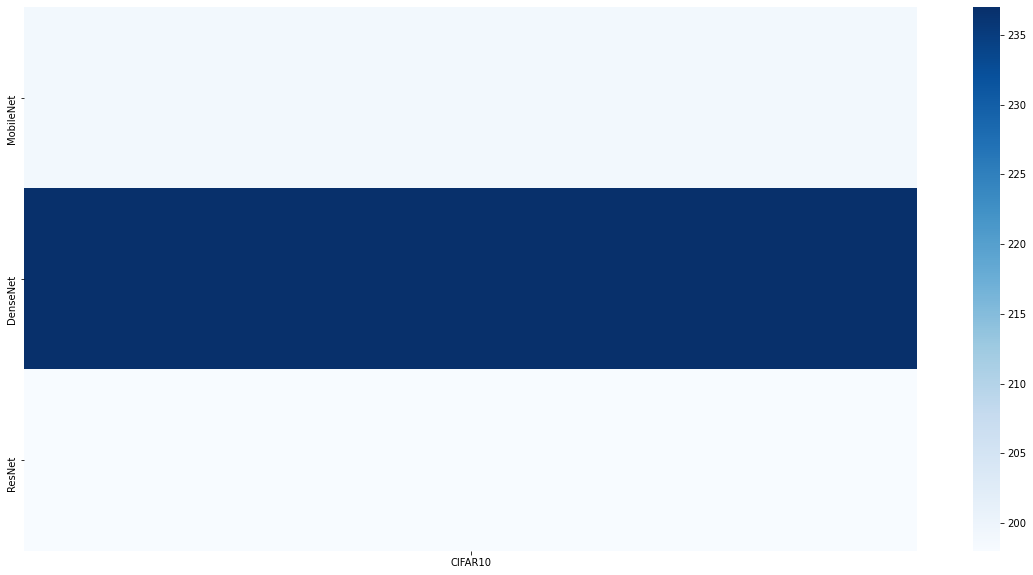

In [13]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(20, 10))
sb.heatmap(experiments_df_ep20, cmap="Blues")
# plt.savefig(f"/home/dev/deepts/plots/heatmap_epoch20_seeds{seed_lim}_{test_type}_size{sample_size}_conf{conf_int}.png", dpi=1000)
plt.show()

# Read the csv and plot 

In [8]:
# conf_int_df = 0.99
"test type can be utest, brunner, t_test"
# test_type = 't_test'
# estimated_max_val = 120
# sample_size_df = 10000

ep_seed5_ep100_df  = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds5_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])
ep_seed10_ep100_df = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds10_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])
ep_seed15_ep100_df = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds15_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])
ep_seed20_ep100_df = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds20_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])
ep_seed25_ep100_df = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds25_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])
ep_seed30_ep100_df = pd.read_csv(f"/datadrive2/image_classification/exp/heatmap/heatmap_seeds30_{test_type}_size{sample_size}_conf{conf_int}.csv",  index_col=[0])


# Make heatmap

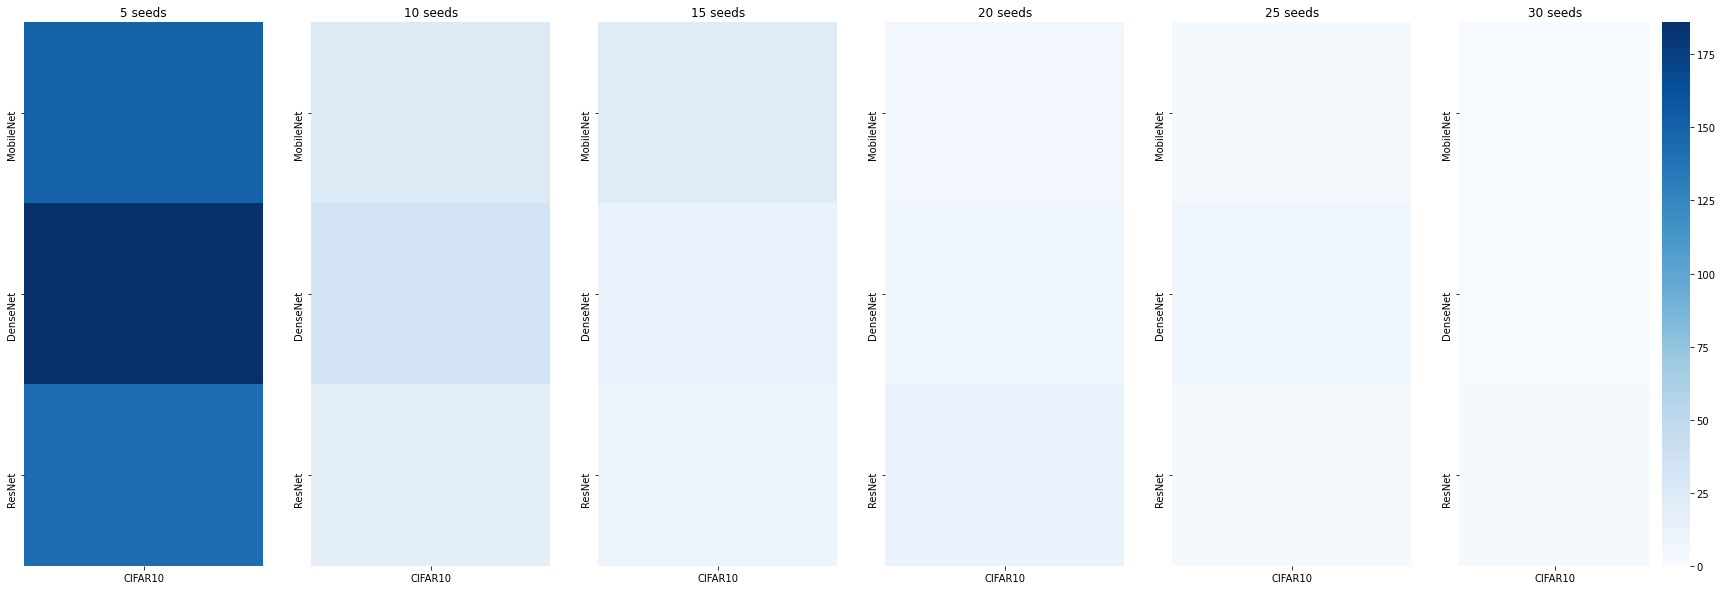

In [22]:
# ploting all the 100 seeds in a row
import seaborn as sb

max_val = max(ep_seed5_ep100_df.max().max(), ep_seed10_ep100_df.max().max(), ep_seed15_ep100_df.max().max(), ep_seed20_ep100_df.max().max(), ep_seed30_ep100_df.max().max())
# max_val = 400

fig, axis = plt.subplots(1, 6, figsize=(30, 10)) 
sb.heatmap(ep_seed5_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[0], cbar=False)
axis[0].set_title("5 seeds")
sb.heatmap(ep_seed10_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[1], cbar=False)
axis[1].set_title("10 seeds")
sb.heatmap(ep_seed15_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[2], cbar=False)
axis[2].set_title("15 seeds")
sb.heatmap(ep_seed20_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[3], cbar=False)
axis[3].set_title("20 seeds")
sb.heatmap(ep_seed25_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[4], cbar=False)
axis[4].set_title("25 seeds")
sb.heatmap(ep_seed30_ep100_df, cmap="Blues", vmin=0, vmax=max_val, ax=axis[5])
axis[5].set_title("30 seeds")

# plt.savefig(f"/datadrive2/image_classification/exp/heatmap/heatmap_all_{test_type}_{conf_int}_unmasked.png", dpi=1000)
plt.show()

In [16]:
ep_seed5_ep100_df.max().max()

458

In [17]:
def mask_df(my_df, threshold=5):
    masked_df = my_df.mask(my_df < threshold, 0)
    masked_df = masked_df.mask(masked_df >= threshold, 1)
    return masked_df

In [18]:
threshold = 100

ep_seed5_ep100_df_masked  =   mask_df(ep_seed5_ep100_df    , threshold=threshold)  
ep_seed10_ep100_df_masked =   mask_df(ep_seed10_ep100_df   , threshold=threshold)
ep_seed15_ep100_df_masked =   mask_df(ep_seed15_ep100_df   , threshold=threshold)
ep_seed20_ep100_df_masked =   mask_df(ep_seed20_ep100_df   , threshold=threshold)
ep_seed25_ep100_df_masked =   mask_df(ep_seed25_ep100_df   , threshold=threshold)
ep_seed30_ep100_df_masked =   mask_df(ep_seed30_ep100_df   , threshold=threshold)

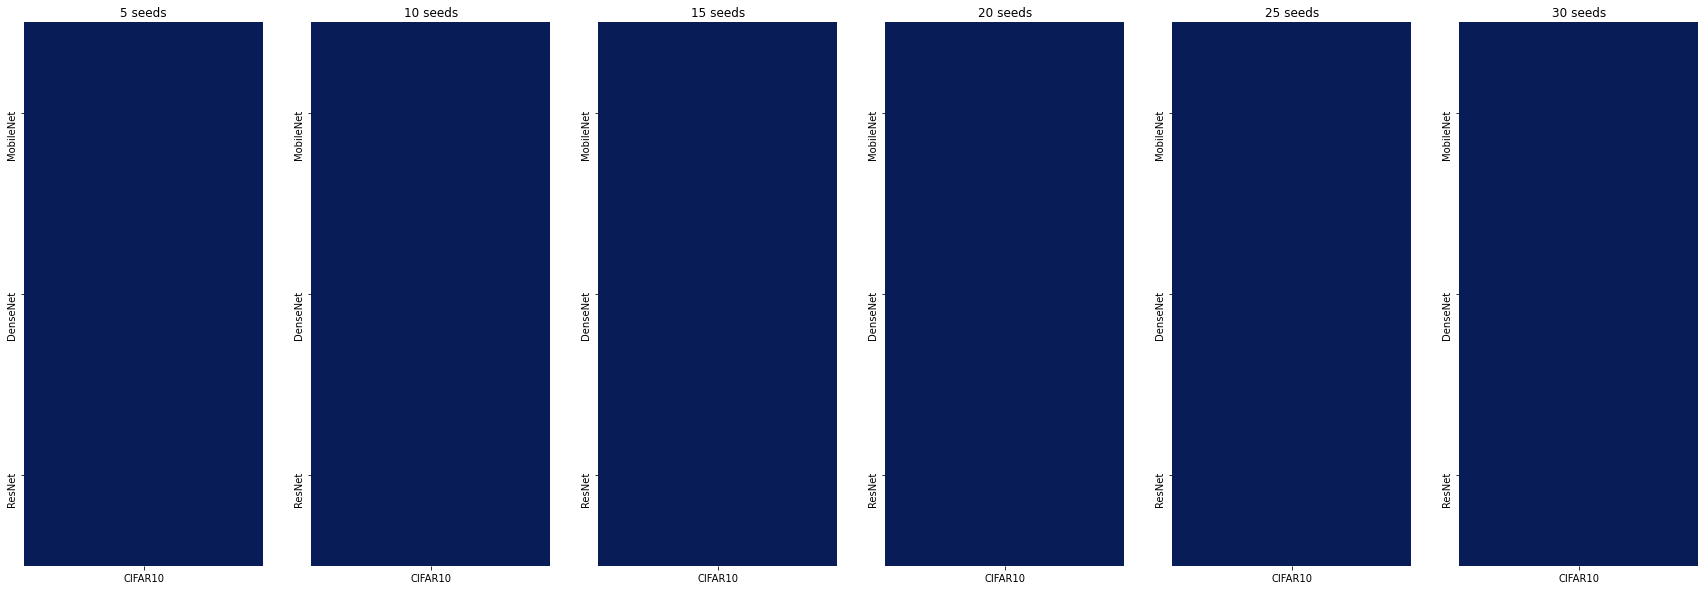

In [19]:
# ploting all the 100 seeds in a row
import seaborn as sb

# max_val = max(ep_seed5_ep100_df.max(), ep_seed10_ep100_df.max(), ep_seed15_ep100_df.max(), ep_seed20_ep100_df.max(), ep_seed30_ep100_df.max())
max_val = 1

fig, axis = plt.subplots(1, 6, figsize=(30, 10)) 
sb.heatmap(ep_seed5_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[0], cbar=False, center=0.5)
axis[0].set_title("5 seeds")
sb.heatmap(ep_seed10_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[1], cbar=False, center=0.5)
axis[1].set_title("10 seeds")
sb.heatmap(ep_seed15_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[2], cbar=False, center=0.5)
axis[2].set_title("15 seeds")
sb.heatmap(ep_seed20_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[3], cbar=False, center=0.5)
axis[3].set_title("20 seeds")
sb.heatmap(ep_seed25_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[4], cbar=False, center=0.5)
axis[4].set_title("25 seeds")
sb.heatmap(ep_seed30_ep100_df_masked, cmap="YlGnBu", vmin=0, vmax=max_val, ax=axis[5], cbar=False, center=0.5)
axis[5].set_title("30 seeds")

# plt.savefig(f"/datadrive2/image_classification/exp/heatmap/heatmap_all_{test_type}_masked{threshold}.png", dpi=1000)
plt.show()

In [20]:
ep_seed5_ep100_df

,CIFAR10
MobileNet,443
DenseNet,293
ResNet,458


# Make line plot

In [9]:
def change_df_format(df_func, sample_size):
    df_func['model'] = df_func.index
    df_func = pd.melt(df_func, id_vars=['model'], value_vars=['CIFAR10'], var_name='dataset', value_name='ratio')
    df_func['Size(n)'] = sample_size
    df_func['ratio'] = df_func['ratio'] / 10000
    return df_func

In [10]:
df_seed5 = change_df_format(ep_seed5_ep100_df, 5)
df_seed10 = change_df_format(ep_seed10_ep100_df, 10)
df_seed15 = change_df_format(ep_seed15_ep100_df, 15)
df_seed20 = change_df_format(ep_seed20_ep100_df, 20)
df_seed25 = change_df_format(ep_seed25_ep100_df, 25)
df_seed30 = change_df_format(ep_seed30_ep100_df, 30)
df_total = pd.concat([df_seed5, df_seed10, df_seed15, df_seed20, df_seed25, df_seed30])
df_total


,model,dataset,ratio,Size(n)
0,MobileNet,CIFAR10,0.0669,5
1,DenseNet,CIFAR10,0.0708,5
2,ResNet,CIFAR10,0.0689,5
0,MobileNet,CIFAR10,0.0481,10
1,DenseNet,CIFAR10,0.0482,10
2,ResNet,CIFAR10,0.0467,10
0,MobileNet,CIFAR10,0.0394,15
1,DenseNet,CIFAR10,0.0396,15
2,ResNet,CIFAR10,0.0381,15
0,MobileNet,CIFAR10,0.0338,20


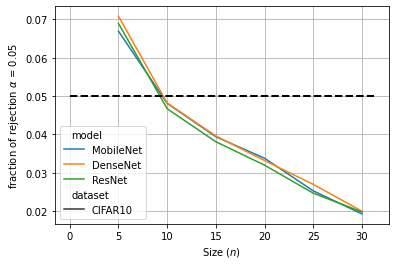

In [12]:
import seaborn as sb
import matplotlib
ALPHA = 0.05

fig = sb.lineplot(data=df_total, x='Size(n)', y='ratio', hue='model', style='dataset', ci=None)
# fig.set(yscale='log')
plt.plot([0, plt.xlim()[-1]], [ALPHA, ALPHA],
        color='black', marker=None, linestyle='dashed', linewidth=2, )

plt.ylabel(fr'fraction of rejection $\alpha$ = {round(1 - conf_int, 3)}')
plt.xlabel(r'Size ($n$)')
# plt.ticklabel_format(style='plain', axis='y', scilimits=(-1000000,1000000))
# from matplotlib.ticker import StrMethodFormatter
# plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
# plt.gca().yaxis.set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.grid(True, which='both')
plt.savefig(f"/datadrive2/image_classification/exp/heatmap/complete/line_all_{test_type}_conf{conf_int}_image.png", dpi=500)
plt.show()